## Project 1
Marc Hernandez, Tilboon Elberier

In [10]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [11]:

# Importing all packages and functions needed for the assignment

import numpy as np
import matplotlib.pyplot as plt
from pickle import dump
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords
from sklearn import metrics

In [12]:
# Setting the random seed variables for repeatability of results
np.random.seed(42)
random.seed(42)

In [13]:
# Importing the dataset required for 
df = pd.read_csv("Project1-ClassificationDataset.csv")
df.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,'Personalize Your NBA App Experience for the '...,'Personalize Your NBA App Experience for the '...,"['original', 'content', 'live', 'slate', 'game...",NaN,['Official Release'],https://www.nba.com/news/nba-app-new-features-...,basketball,sports
1,'Mike Will attends the Pre-GRAMMY Gala and GRA...,'Mike WiLL Made-It has secured a partnership w...,"['lead', 'espn', 'nbas', 'madeit', 'nba', 'lat...",2023-10-18 16:22:29+00:00,['Marc Griffin'],https://www.vibe.com/news/entertainment/mike-w...,basketball,sports
2,'The Golden State Warriors are struggling to f...,'The Golden State Warriors are struggling to f...,"['insider', 'york', 'thing', 'nbc', 'tag', 'nb...",NaN,[],https://www.nbcnewyork.com/tag/featured-nba/,basketball,sports
3,"'On Nov. 28, the NBA and Nike will collaborate...","'On Nov. 28, the NBA and Nike will collaborate...","['watch', 'telecast', 'ultimate', 'membership'...",NaN,['Official Release'],https://www.nba.com/news/watch-nba-games-ultim...,basketball,sports
4,'The NBA announced additions and innovations t...,'The NBA announced additions and innovations t...,"['experience', 'bring', 'media', 'crennan', 'n...",2023-10-17 12:00:17+00:00,"['Chris Novak', 'About Chris Novak']",https://awfulannouncing.com/tech/nba-app-2023-...,basketball,sports


### QUESTION 1: Provide answers to the following questions:
- Overview: How many rows (samples) and columns (features) are present in the dataset? 

- Histograms: Plot 3 histograms on :

    (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis;

    (b) The column leaf label – class on the x-axis; 

    (c) The column root label – class on the x-axis.

- Interpret Plots: Provide qualitative interpretations of the histograms.

The total number of rows in the dataframe 3476
The total number of columns (features) 8


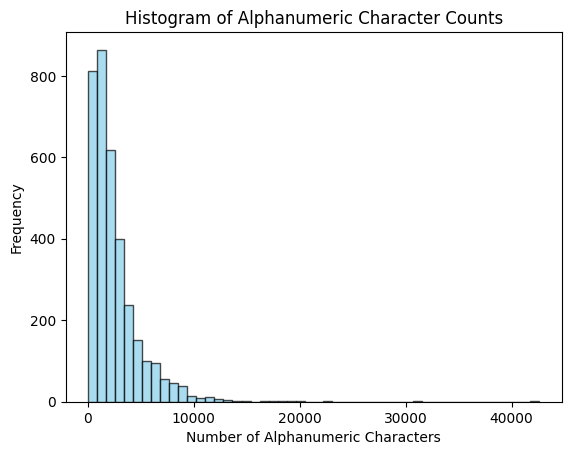

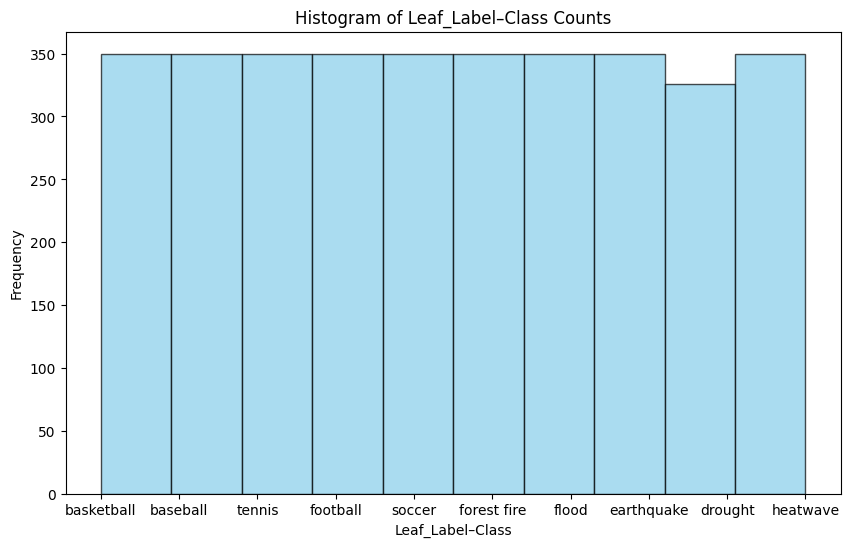

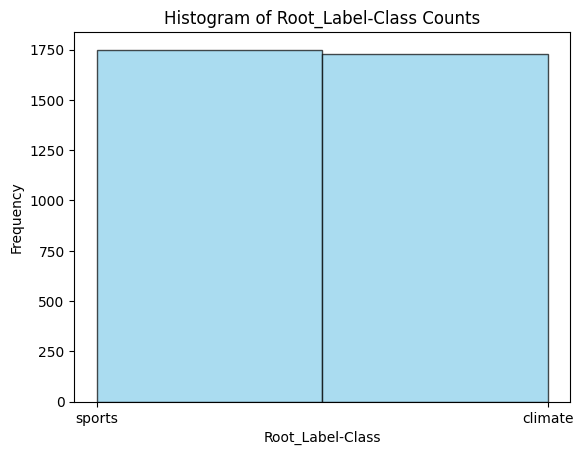

In [14]:
# Code for question 1
print("The total number of rows in the dataframe",df.shape[0])
print("The total number of columns (features)", df.shape[1])

# Histogram a.
df['count'] = df['full_text'].apply(lambda x: sum(char.isalnum() for char in x))
df['count'].plot.hist(bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Alphanumeric Character Counts')
plt.xlabel('Number of Alphanumeric Characters')
plt.ylabel('Frequency')
plt.show()

# Histogram b.
plt.figure(figsize=(10, 6))
plt.hist(df['leaf_label'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Leaf_Label–Class Counts')
plt.xlabel('Leaf_Label–Class')
plt.ylabel('Frequency')
plt.show()

# Histogram c.
plt.hist(df['root_label'], bins=2, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Root_Label-Class Counts')
plt.xlabel('Root_Label-Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keep the x-axis labels horizontal
plt.show()

The previous histograms have provided us with the following information, part (a) demonstrates that the majority of the *full_text* feature contains entries that are within 40000 alpha-numeric characters, with a majority of the entries being less than 10000 characters. Furthermore, in the graphs (b) and (c) we can observe an even distribution of each category across all known types in our hierarchy, which enables future analysis of the data to properly weigh the features against one another due to their frequencies being nearly identical.

### QUESTION 2: Report the number of training and testing samples.

In [15]:
# Code for question 2
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

print("The total number of smaples in the training set is", train.shape[0])
print("The total number of smaples in the testing set is", test.shape[0])

The total number of smaples in the training set is 2780
The total number of smaples in the testing set is 696


### QUESTION 3: Use the following specs to extract features from the textual data:
- Before doing anything, please clean each data sample using the code block provided above.
This function helps remove many but not all HTML artefacts from the crawler’s output. You
can also build your own cleaning module if you find this function to be ineffective.
- Use the “english” stopwords of the CountVectorizer
- Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
- Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos tag
- Use min df=3

Please answer the following questions:
- What are the pros and cons of lemmatization versus stemming? How do these processes affect
the dictionary size?
- min df means minimum document frequency. How does varying min df change the TF-IDF
matrix?
- Should I remove stopwords before or after lemmatizing? Should I remove punctuations before
or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall
that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position
of every word based on the sentence structure.
- Report the shape of the TF-IDF-processed train and test matrices. The number of rows should
match the results of Question 2. The number of columns should roughly be in the order of
k ×103. This dimension will vary depending on your exact method of cleaning and lemmatizing
and that is okay.

In [16]:
# Function for cleaning the entries in the full_text feature
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    texter = re.sub(r'[^a-zA-Z\s]', '', texter) # added to get rid of symbols and numbers other than letter
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [17]:
# Spec 1: Cleaning the full_text feature in the training and testing set
train['full_text'] = train['full_text'].map(clean)
test['full_text'] = test['full_text'].map(clean)

In [18]:
# Spec 2 & 5: Use the english stopwards of the CountVectorizer, Use min_df=3
min_df = 3
count_vect = CountVectorizer(min_df=min_df, stop_words='english')

In [20]:
# nltk.download()#, if you need "corpora/wordnet", choose it
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
wnl = nltk.wordnet.WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'
    
def lemmatize(data):
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in nltk.pos_tag(nltk.word_tokenize(data))]

def stem(data):
    return [wnl.lemmatize(word.lower()) for word in nltk.word_tokenize(data)]

[nltk_data] Downloading package punkt to /Users/tilboon/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/tilboon/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /Users/tilboon/nltk_data...


- Bullet 1, Question 3
  - A pro of lemmatization over stemming is that stemmed words may not match the context of the sentance that they were found in, as it relies on a simple rules to find the root word, while lemmatixation attempts to find the root word using linguistics.
  - A con of lemmatization when compared to stemming is its additonal layer of computational complexity, and its requirement of parts-of-speech which is used to better understand the context of the words being processed.
- Bullet 2, Question 3
  - As we increase the value of *min_df*, we observe that the total number of collected words begins to decline as less frequently occuring words may be less valuable to our model than other words occuring frequently throughout the text.
- Bullet 3, Question 3
  - Punctuation and numbers can be removed prior to lemmatizing as they do not have a large influence on sentance structure and meaning of words, however, stop words should be removed after lemmatizing, as they can play an intergral role in identifying the context of our words of interest.
- Bullet 4, Question 3
  - As expected with a value of *min_df* = 3, we have a matching number of rows to the result observed in question 2.

### QUESTION 4: Reduce the dimensionality of the data using the methods above:
- Plot the explained variance ratio across multiple different k = [1, 5, 10, 25, 50, 100, 500, 1000]
for LSI and for the next few sections choose k = 25. What does the explained variance ratio
plot look like? What does the plot’s concavity suggest?
- With k = 25 found in the previous sections, calculate the reconstruction residual MSE error
when using LSI and NMF – they both should use the same k = 25. Which one is larger, the $||X − WH||_{F}^2$ in NMF or the $||X − U_k Σ_k V_{k}^T||_{F}^2$ in LSI and why?

In [ ]:
# Code for Question 4

### QUESTION 5: Compare and contrast hard-margin and soft-margin linear SVMs:
- Train two linear SVMs:
- Train one SVM with γ = 2000 (hard margin), another with γ = 0.0005 (soft margin).
- Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall,
precision and F-1 score of both SVM classifiers on the testing set. Which one performs
better? What about for γ = 100000?
- What happens for the soft margin SVM? Why is the case? Analyze in terms of the
confusion matrix.
  - Does the ROC curve reflect the performance of the soft-margin SVM? Why?
- Use cross-validation to choose γ (use average validation 3 accuracy to compare): Using a
5-fold cross-validation, find the best value of the parameter γ in the range {10k| − 3 ≤ k ≤
6, k ∈ Z}. Again, plot the ROC curve and report the confusion matrix and calculate the
accuracy, recall precision and F-1 score of this best SVM.

In [ ]:
# Code for Question 5

### QUESTION 6: Evaluate a logistic classifier:
- Train a logistic classifier without regularization (you may need to come up with some way to
approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC
curve and report the confusion matrix and calculate the accuracy, recall precision and F-1
score of this classifier on the testing set.
- Find the optimal regularization coefficient:
  - Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the op-
timal regularization strength in the range {10k|−5 ≤ k ≤ 5, k ∈ Z} for logistic regression
with L1 regularization and logistic regression with L2 regularization, respectively.
  - Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classi-
fiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best
parameters you found from the part above), using test data.
  - How does the regularization parameter affect the test error? How are the learnt coeffi-
cients affected? Why might one be interested in each type of regularization?
  - Both logistic regression and linear SVM are trying to classify data points using a linear
decision boundary. What is the difference between their ways to find this boundary? Why
do their performances differ? Is this difference statistically significant?

In [ ]:
# Code for Question 6

### QUESTION 7: Evaluate and profile a Naive Bayes classifier: 
Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and
F-1 score of this classifier on the testing set.

In [ ]:
# Code for Question 7

### QUESTION 8: In this part, you will attempt to find the best model for binary classification.
- Construct a Pipeline that performs feature extraction, dimensionality reduction and classifi-
cation;
- The evaluation of each combination is performed with 5-fold cross-validation (use the average
validation set accuracy across folds).
- In addition to any other hyperparameters you choose, your gridsearch must at least include:
- What are the 5 best combinations? Report their performances on the testing set.

In [ ]:
# Code for Question 8

### QUESTION 9: In this part, we aim to learn classifiers on the documents belonging to unique classes in the column leaf label.
Perform Naive Bayes classification and multiclass SVM classification (with both One VS One and
One VS the rest methods described above) and report the confusion matrix and calculate the
accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class
imbalance issue in the One VS the rest model?
In addition, answer the following questions:
- In the confusion matrix you should have an 10 × 10 matrix where 10 is the number of unique
labels in the column leaf label. Please make sure that the order of these labels is as
follows:

    *map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis", 3:"football", 4:"soccer", 5:"forest fire", 6:"flood", 7:"earthquake", 8:"drought", 9:"heatwave"}*

    Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the
    major diagonal? What does this mean?
    
- Based on your observation from the previous part, suggest a subset of labels that should be
merged into a new larger label and recompute the accuracy and plot the confusion matrix.
How did the accuracy change in One VS One and One VS the rest?
- Does class imbalance impact the performance of the classification once some classes are
merged? Provide a resolution for the class imbalance and recompute the accuracy and plot
the confusion matrix in One VS One and One VS the rest?.

In [ ]:
# Code for Question 9

### QUESTION 10: Read the paper about GLoVE embeddings - found here and answer the following subquestions:
a. Why are GLoVE embeddings trained on the ratio of co-occurrence probabilities rather than
the probabilities themselves?

b. In the two sentences: “James is running in the park.” and “James is running for the
presidency.”, would GLoVE embeddings return the same vector for the word running in both
cases? Why or why not?

c. What do you expect for the values of,
||GLoVE["left"] - $GLoVE["right"]||_2$, ||GLoVE["wife"] - $GLoVE["husband"]||_2$ and
||GLoVE["wife"] - $GLoVE["orange"]||_2$ ? Compare these values.

d. Given a word, would you rather stem or lemmatize the word before mapping it to its GLoVE
embedding?

In [ ]:
# Code for Question 10

### QUESTION 11: For the binary classification task distinguishing the “sports” class and “climate” class:
a. Describe a feature engineering process that uses GLoVE word embeddings to represent each
document. You have to abide by the following rules:

- A representation of a text segment needs to have a vector dimension that CANNOT
exceed the dimension of the GLoVE embedding used per word of the segment.
- You cannot use TF-IDF scores (or any measure that requires looking at the complete
dataset) as a pre-processing routine.
- Important: In this section, feel free to use raw features from any column in the original
data file not just full text. The column keywords might be useful... or not. Make
sure that your result achieves an accuracy of at least 92%.
- To aggregate these words into a single vector consider normalization the vectors, averaging
across the vectors.

b. Select a classifier model, train and evaluate it with your GLoVE-based feature. If you are doing
any cross-validation, please make sure to use a limited set of options so that your code finishes
running in a reasonable amount of time.

In [ ]:
# Code for Question 11

### QUESTION 12: Graphing 
Plot the relationship between the dimension of the pre-trained GLoVE embedding
and the resulting accuracy of the model in the classification task. Describe the observed trend. Is
this trend expected? Why or why not? In this part use the different sets of GLoVE vectors from the
link.

In [ ]:
# Code for Question 12

### QUESTION 13: Compare and contrast the two visualizations. 
Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project.

In [ ]:
# Code for Question 13